# Aula 2 - Parte Prática - Policy Gradients 

## Introdução

Nesse segundo notebook vamos aprender ...

### Objetivos:

- Entender a abordagem de otimização de políticas como busca no espaço de parâmetros da política
- Implementar um primeiro agente baseado no algoritmo REINFORCE
- Familiarizar-se com a API básica de construção de modelos (i.e., redes neurais) em Keras
- Familiarizar-se com métodos de Deep Learning usando TensorFlow 2.X

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from utils.memory import OnPolicyReplay

In [2]:
# sanity check
assert tf.__version__ == '2.1.0'
assert tf.executing_eagerly()

## 1. Implementando políticas estocásticas em tf.Keras 

In [3]:
tfd = tfp.distributions

### 1.1 Caso discreto

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3),
    tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t))
])

In [5]:
inputs = tf.random.normal(shape=(10, 5))
print(inputs)

tf.Tensor(
[[-0.38117597  0.67415327 -0.7539969  -0.9630399  -1.123436  ]
 [-0.02243149 -1.4392524   0.5073562  -0.40109003  0.5556543 ]
 [-0.48144257  0.43146038 -0.8288045  -1.274146   -0.77778256]
 [-0.58085376 -0.02389099  0.09542119 -1.7419342   1.4345952 ]
 [-0.617048    0.34856266  0.388757   -0.13467874 -0.878634  ]
 [-1.0132031  -1.0451635  -0.5513928  -0.6848802  -0.1826988 ]
 [ 1.4384787   1.1670514   0.53341234 -1.3166772   0.35310978]
 [ 0.30137643  1.2014254  -0.05963652 -0.4559122   0.00213528]
 [ 1.199887   -1.0257902  -1.0454237   0.44551042  1.2113535 ]
 [-0.9662131  -1.1385068  -0.8423603  -0.94637465  0.25711676]], shape=(10, 5), dtype=float32)


In [6]:
dist = model(inputs)
print(dist)

tfp.distributions.Categorical("sequential_distribution_lambda_Categorical", batch_shape=[10], event_shape=[], dtype=int32)


In [7]:
sample = dist.sample()
print(sample)

tf.Tensor([0 0 1 0 0 0 0 0 0 2], shape=(10,), dtype=int32)


In [8]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor(
[-0.94422626 -1.1742859  -1.2091149  -0.9334638  -0.96630484 -0.91994655
 -0.8061617  -1.0398461  -0.8889093  -0.9823012 ], shape=(10,), dtype=float32)


In [9]:
def build_discrete_policy(obs_space, action_space, hidden_layers, activation="relu"):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    Categorical = tfd.Categorical
    
    policy_net_layers = []

    policy_net_layers.append(Input(shape=obs_space.shape, name="Input"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))
    
    policy_net_layers.append(Dense(units=action_space.n, name="Logits"))
    policy_net_layers.append(DistributionLambda(lambda t: Categorical(logits=t), name="Categorical"))
                                     
    return tf.keras.Sequential(policy_net_layers)


In [10]:
env = gym.make("MountainCar-v0")

hidden_layers = [64, 64]
activation = "relu"

policy = build_discrete_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.Categorical("sequential_1_Categorical_Categorical", batch_shape=[1], event_shape=[], dtype=int32)


In [11]:
!pip3 install pydot graphviz
import pydot

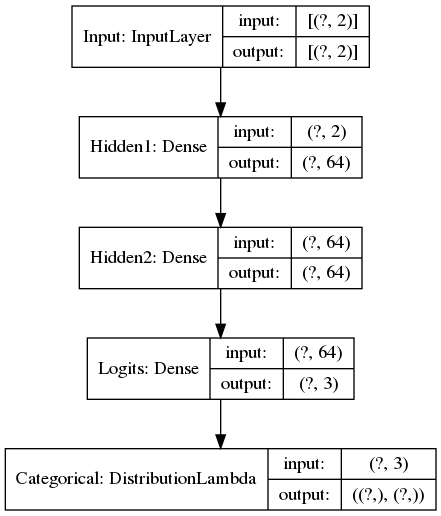

In [12]:
tf.keras.utils.plot_model(policy, show_shapes=True)

### 1.2 Caso contínuo 

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="tanh", input_shape=(10,)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(10),
    tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=[1e-2] * 10))
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [14]:
inputs = tf.random.normal(shape=(4, 10))
print(inputs)

tf.Tensor(
[[-0.48297957  0.39565054 -0.13180265  0.15864636 -1.022307   -0.7262729
   0.4852487   0.9155715   1.3631878   0.22315325]
 [ 0.3463776   0.65311915 -0.4067139  -1.1105392   0.8124608   0.88023186
   1.5679476   0.7566002   2.33942    -2.3304272 ]
 [ 0.22862619  0.29199752 -0.5528668   0.8849869  -0.45011437  0.6304047
  -0.6618974   0.7920512  -0.7272325  -1.1838597 ]
 [ 0.90224713  0.6715434  -1.8042321   0.23280478  0.958096   -0.92791104
  -0.740342   -0.10301289  0.4112148   0.24718492]], shape=(4, 10), dtype=float32)


In [15]:
dist = model(inputs)
print(dist)

tfp.distributions.MultivariateNormalDiag("sequential_2_distribution_lambda_1_MultivariateNormalDiag", batch_shape=[4], event_shape=[10], dtype=float32)


In [16]:
sample = dist.sample()
print(sample)

tf.Tensor(
[[-0.09182841 -0.88546044  0.25922665  0.11051325  0.1286054   0.39434695
   0.06973037 -0.18844903 -0.19004424 -0.196487  ]
 [-0.28904453 -0.8687308   0.38428316 -0.24818115  0.45680872  0.5223647
   0.0760092   0.48077393  1.2401497  -0.06695284]
 [ 0.1585551   0.5244401  -0.13707007  0.02476116 -0.43609387 -0.02491118
  -0.63263327  0.11772902  0.01703276  0.2572209 ]
 [-0.3699251   0.01731236  0.48223862  0.02565642 -0.07981469  0.11122942
   0.07042368  0.4726179   0.22646295  0.6188859 ]], shape=(4, 10), dtype=float32)


In [17]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor([32.44487  35.133545 32.647236 30.428852], shape=(4,), dtype=float32)


In [18]:
def build_continuous_policy(obs_space, action_space, hidden_layers, activation="relu", scale_diag=1e-2):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    MultivariateNormalDiag = tfd.MultivariateNormalDiag
    
    policy_net_layers = []
    
    policy_net_layers.append(Input(shape=obs_space.shape, name="Input"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))

    policy_net_layers.append(Dense(units=action_space.shape[0], name="Params"))
    policy_net_layers.append(DistributionLambda(
        lambda t: MultivariateNormalDiag(loc=t, scale_diag=[scale_diag] * action_space.shape[0]),
        name="Gaussian"
    ))
                                     
    return tf.keras.Sequential(policy_net_layers)

In [19]:
env = gym.make("MountainCarContinuous-v0")

hidden_layers = [32, 32, 32]
activation = "elu"

policy = build_continuous_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.MultivariateNormalDiag("sequential_3_Gaussian_MultivariateNormalDiag", batch_shape=[1], event_shape=[1], dtype=float32)


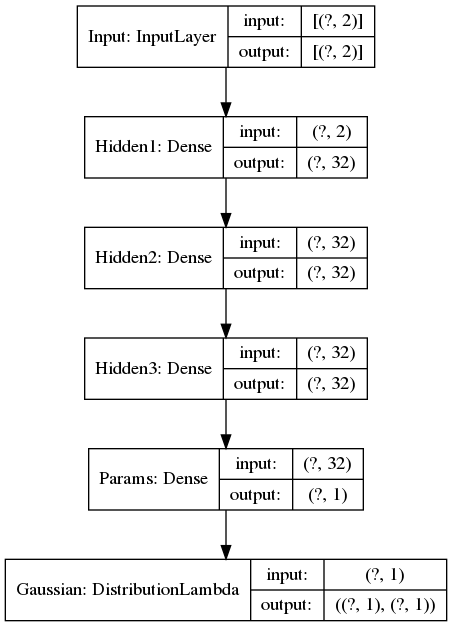

In [20]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## 2. Função objetivo em Policy Gradients (*surrogate loss*) 

In [21]:
env = gym.make("MountainCarContinuous-v0")

memory = OnPolicyReplay()

total_experiences = 0
n_episodes = 5
total_rewards = []

for _ in range(n_episodes):
    total_reward = 0.0
    obs = env.reset()
    while True:
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        memory.update(obs, action, reward, next_obs, done)
        total_reward += reward
        next_obs = obs
        if done:
            total_rewards.append(total_reward)
            break

batch = memory.sample()

### 2.1 Calculando log-prob da escolha da ação 

In [22]:
def compute_log_probs(batch, policy):
    states, actions = batch["states"], batch["actions"]
    n_episodes = len(states)
    
    log_probs = []
    for episode in range(n_episodes):
        states_ = tf.constant(states[episode], dtype=tf.float32)
        actions_ = tf.constant(actions[episode], dtype=tf.float32)
        action_dist = policy(states_)
        log_probs.append(action_dist.log_prob(actions_))
        
    return np.array(log_probs)

In [23]:
log_probs = compute_log_probs(batch, policy)
print(log_probs.shape)

(5, 999)


### 2.2 Calculando retornos de episódios

$$
\hat{R}_t = \sum_{t'=t}^T r_{t'}
$$

In [24]:
def compute_returns(batch):
    rewards = batch["rewards"]
    n_episodes = len(rewards)

    returns = []

    for episode in range(n_episodes):
        episode_returns = []
        total_reward = 0.0

        for i in range(len(rewards[episode]) - 1, -1, -1):
            reward = rewards[episode][i]
            total_reward += reward
            episode_returns.append(total_reward)
        
        episode_returns = episode_returns[::-1]
        returns.append(episode_returns)

    return np.array(returns)

In [25]:
returns = compute_returns(batch)
print(returns.shape)

assert len(returns) == n_episodes
assert all(np.allclose(returns[i][0], total_rewards[i]) for i in range(n_episodes))
assert all(np.allclose(np.cumsum(batch["rewards"][i][::-1])[::-1], returns[i]) for i in range(n_episodes))

(5, 999)


### 2.3 Implementação do *surrogate loss*: combinando log-prob e retornos 

## 3. Agente REINFORCE 

## 4. Treinamento do agente

## 5. Experimentos 